In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
from statistics import median
from rsi import apply as rsi

import pyfinancialdata
import trade_functions

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

In [3]:
# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)

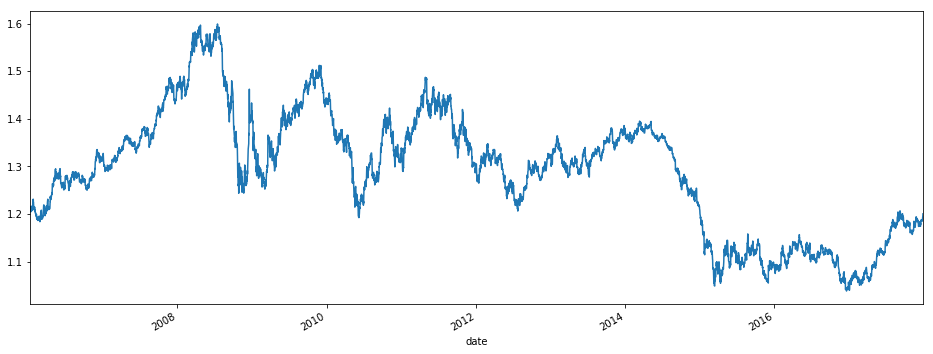

In [4]:
price_data['price'].plot(figsize=(16,6))

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 4677, test size 2338


In [6]:
episode=1000
batch_size=10

In [7]:
train_data.head(5)

,date,price,rsi
0,2006-01-10 00:00:00,1.20892,68.701478
1,2006-01-10 12:00:00,1.20610,62.868143
2,2006-01-11 00:00:00,1.20818,65.203049
3,2006-01-11 12:00:00,1.21380,70.561870
4,2006-01-12 00:00:00,1.21368,70.314140


In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: -863 pips, median trade count: 732
....................
episode: 40/1000
median profit: -443 pips, median trade count: 660
....................
episode: 60/1000
median profit: 332 pips, median trade count: 594
....................
episode: 80/1000
median profit: 771 pips, median trade count: 604
....................
episode: 100/1000
median profit: 1173 pips, median trade count: 564
....................
episode: 120/1000
median profit: 1266 pips, median trade count: 546
....................
episode: 140/1000
median profit: 1890 pips, median trade count: 526
....................
episode: 160/1000
median profit: 2199 pips, median trade count: 526
....................
episode: 180/1000
median profit: 2454 pips, median trade count: 509
.

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124870). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


...................
episode: 200/1000
median profit: 2689 pips, median trade count: 497
....................
episode: 220/1000
median profit: 2857 pips, median trade count: 488
....................
episode: 240/1000
median profit: 2990 pips, median trade count: 467
....................
episode: 260/1000
median profit: 2990 pips, median trade count: 451
....................
episode: 280/1000
median profit: 2980 pips, median trade count: 437
....................
episode: 300/1000
median profit: 2887 pips, median trade count: 432
....................
episode: 320/1000
median profit: 3015 pips, median trade count: 432
....................
episode: 340/1000
median profit: 3189 pips, median trade count: 414
....................
episode: 360/1000
median profit: 3277 pips, median trade count: 406
....................
episode: 380/1000
median profit: 3318 pips, median trade count: 404
....................
episode: 400/1000
median profit: 3239 pips, median trade count: 411
....................
e

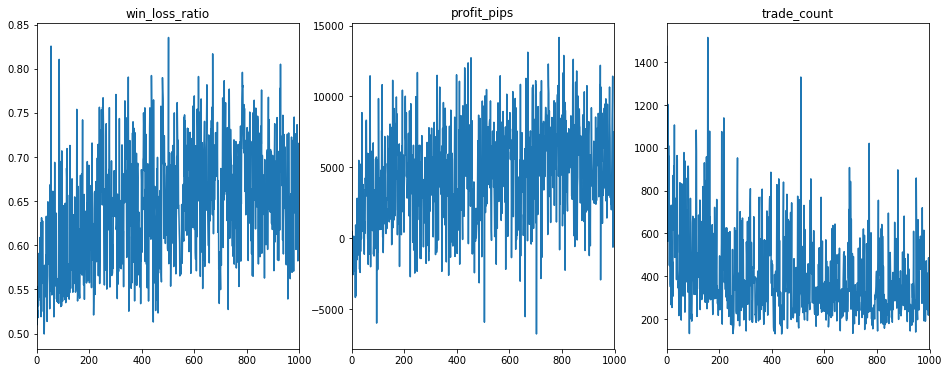

In [10]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [11]:
agent.save('trained-model.h5')

## Test

In [12]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

# Uncomment to load trained model from latest saved
# agent = DQNAgent(state_size, action_size)
# latest_model_file = max(glob.glob('*.h5'), key=os.path.getctime)
# print('loading model: {0}'.format(latest_model_file))
# agent.load(latest_model_file)

In [13]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [14]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 3748.199999999997 pips


In [ ]:
test_results.hist(column='account_balance_pips', bins=60)